# Measures branching in C++ from python

This notebook looks into a couple of ways to write code, which one is efficient, which one is not when it comes to write fast and short loops. Both experiments are around [branching](https://en.wikipedia.org/wiki/Branch_predictor). The notebook relies on C++ code implemented in [cbenchmark.cpp](https://github.com/sdpython/cpyquickhelper/blob/master/cpyquickhelper/numbers/cbenchmark.cpp) and
[repeat_fct.h](https://github.com/sdpython/cpyquickhelper/blob/master/cpyquickhelper/numbers/repeat_fct.h).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

[numpy](http://www.numpy.org/) is multithreaded. For an accurate comparison, this needs to be disabled. This can be done as follows or by setting environment variable ``MKL_NUM_THREADS=1``.

In [3]:
try:
    import mkl
    mkl.set_num_threads(1)
except ModuleNotFoundError as e:
    print('mkl not found', e)
    import os
    os.environ['MKL_NUM_THREADS']='1'

## First experiment: comparison C++ syntax

This all started with article [Why is it faster to process a sorted array than an unsorted array?](https://stackoverflow.com/questions/11227809/why-is-it-faster-to-process-a-sorted-array-than-an-unsorted-array/11227902#11227902). It compares different implementation fo the following function for which we try different implementations for the third line in next cell. The last option is taken
[Checking whether a number is positive or negative using bitwise operators](https://stackoverflow.com/questions/3779202/checking-whether-a-number-is-positive-or-negative-using-bitwise-operators) which avoids [branching](https://en.wikipedia.org/wiki/Branch_predictor).

In [4]:
# int nb = 0;
# for(auto it = values.begin(); it != values.end(); ++it)
#     if (*it >= th) nb++; // this line changes
#     if (*it >= th) nb++; // and is repeated 10 times inside the loop.
#     // ... 10 times
# return nb;

The third line is also repeated 10 times to avoid the loop being too significant. 

In [5]:
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_A, measure_scenario_B
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_C, measure_scenario_D
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_E, measure_scenario_F
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_G, measure_scenario_H
from cpyquickhelper.numbers.cbenchmark_dot import measure_scenario_I, measure_scenario_J

In [6]:
import pandas

def test_benchmark(label, values, th, repeat=10, number=20):
    funcs = [(k, v) for k, v in globals().copy().items() if k.startswith("measure_scenario")]
    rows = []
    for k, v in funcs:
        exe = v(values, th, repeat, number)
        d = exe.todict()
        d['doc'] = v.__doc__.split('``')[1]
        d['label'] = label
        d['name'] = k
        rows.append(d)        
    df = pandas.DataFrame(rows)
    return df

test_benchmark("sorted", list(range(10)), 5)

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,6.518500e-08,2.870060e-07,if (values[i] >= th) ++nb;,sorted,1.581000e-06,0.000001,measure_scenario_A,20.0,10.0
1,5.926000e-08,2.583084e-07,if (*it >= th) ++nb;,sorted,1.186000e-06,0.000001,measure_scenario_B,20.0,10.0
2,6.123500e-08,2.682277e-07,if (*it >= th) nb++;,sorted,1.580000e-06,0.000001,measure_scenario_C,20.0,10.0
3,1.185000e-08,6.738195e-08,nb += *it >= th ? 1 : 0;,sorted,3.950000e-07,0.000000,measure_scenario_D,20.0,10.0
4,6.123500e-08,2.682277e-07,if (*it >= th) nb += 1;,sorted,1.580000e-06,0.000001,measure_scenario_E,20.0,10.0
5,7.900000e-09,5.530000e-08,nb += (*it - th) >= 0 ? 1 : 0;,sorted,3.950000e-07,0.000000,measure_scenario_F,20.0,10.0
6,1.580500e-08,7.742840e-08,nb += (*it - th) < 0 ? 1 : 0;,sorted,3.960000e-07,0.000000,measure_scenario_G,20.0,10.0
7,1.383000e-08,7.261929e-08,nb += *it < th ? 1 : 0;,sorted,3.960000e-07,0.000000,measure_scenario_H,20.0,10.0
8,1.777500e-08,8.188513e-08,nb += 1 ^ ((unsigned int)(*it) >> (sizeof(int)...,sorted,3.950000e-07,0.000000,measure_scenario_I,20.0,10.0
9,1.383000e-08,7.261929e-08,nb += values[i] >= th ? 1 : 0;,sorted,3.960000e-07,0.000000,measure_scenario_J,20.0,10.0


Times are not very conclusive on such small lists.

In [7]:
values = list(range(100000))
df_sorted = test_benchmark("sorted", values, len(values)//2, repeat=200)
df_sorted

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,0.001116,0.004947,if (values[i] >= th) ++nb;,sorted,0.047184,0.014096,measure_scenario_A,20.0,200.0
1,0.001136,0.005057,if (*it >= th) ++nb;,sorted,0.038252,0.014688,measure_scenario_B,20.0,200.0
2,0.001133,0.005100,if (*it >= th) nb++;,sorted,0.044802,0.013577,measure_scenario_C,20.0,200.0
3,0.000118,0.000528,nb += *it >= th ? 1 : 0;,sorted,0.004973,0.001436,measure_scenario_D,20.0,200.0
4,0.000831,0.003742,if (*it >= th) nb += 1;,sorted,0.048095,0.013466,measure_scenario_E,20.0,200.0
5,0.000118,0.000564,nb += (*it - th) >= 0 ? 1 : 0;,sorted,0.013677,0.001338,measure_scenario_F,20.0,200.0
6,0.000170,0.000786,nb += (*it - th) < 0 ? 1 : 0;,sorted,0.007175,0.001582,measure_scenario_G,20.0,200.0
7,0.000090,0.000414,nb += *it < th ? 1 : 0;,sorted,0.004574,0.001296,measure_scenario_H,20.0,200.0
8,0.000119,0.000518,nb += 1 ^ ((unsigned int)(*it) >> (sizeof(int)...,sorted,0.002834,0.002243,measure_scenario_I,20.0,200.0
9,0.000081,0.000360,nb += values[i] >= th ? 1 : 0;,sorted,0.004324,0.001459,measure_scenario_J,20.0,200.0


The article some implementations will be slower if the values are not sorted.

In [8]:
import random
random.shuffle(values)
values = values.copy()
values[:10]

[73680, 56372, 84502, 10263, 93712, 12350, 98785, 54243, 7299, 30309]

In [9]:
df_shuffled = test_benchmark("shuffled", values, len(values)//2, repeat=200)
df_shuffled

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,0.000704,0.003076,if (values[i] >= th) ++nb;,shuffled,0.019643,0.013091,measure_scenario_A,20.0,200.0
1,0.000697,0.003042,if (*it >= th) ++nb;,shuffled,0.016656,0.013203,measure_scenario_B,20.0,200.0
2,0.000761,0.003440,if (*it >= th) nb++;,shuffled,0.027062,0.013112,measure_scenario_C,20.0,200.0
3,0.000128,0.000563,nb += *it >= th ? 1 : 0;,shuffled,0.004075,0.001579,measure_scenario_D,20.0,200.0
4,0.001281,0.005590,if (*it >= th) nb += 1;,shuffled,0.028929,0.018232,measure_scenario_E,20.0,200.0
5,0.000126,0.000554,nb += (*it - th) >= 0 ? 1 : 0;,shuffled,0.003189,0.001542,measure_scenario_F,20.0,200.0
6,0.000144,0.000634,nb += (*it - th) < 0 ? 1 : 0;,shuffled,0.005403,0.001844,measure_scenario_G,20.0,200.0
7,0.000128,0.000560,nb += *it < th ? 1 : 0;,shuffled,0.003976,0.001567,measure_scenario_H,20.0,200.0
8,0.000223,0.000974,nb += 1 ^ ((unsigned int)(*it) >> (sizeof(int)...,shuffled,0.007231,0.002795,measure_scenario_I,20.0,200.0
9,0.000140,0.000687,nb += values[i] >= th ? 1 : 0;,shuffled,0.016393,0.001547,measure_scenario_J,20.0,200.0


In [10]:
df = pandas.concat([df_sorted, df_shuffled])
dfg = df[["doc", "label", "average"]].pivot("doc", "label", "average")

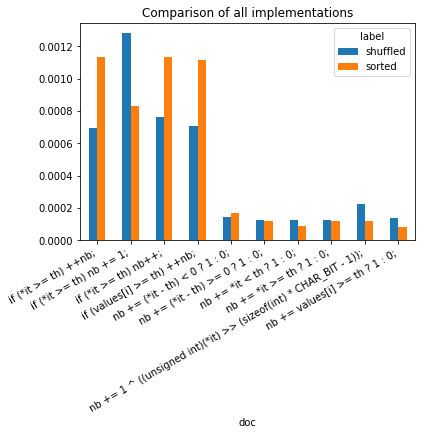

In [11]:
ax = dfg.plot.bar(rot=30)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
ax.set_title("Comparison of all implementations");

It seems that inline tests (``cond ? value1 : value2``) do not stop the branching and it should be used whenever possible.

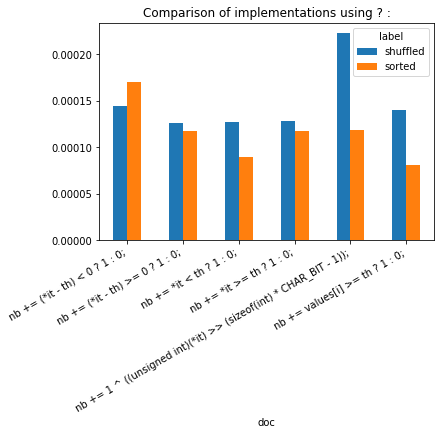

In [12]:
sdf = df[["doc", "label", "average"]]
dfg2 = sdf[sdf.doc.str.contains('[?^]')].pivot("doc", "label", "average")
ax = dfg2.plot.bar(rot=30)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
ax.set_title("Comparison of implementations using ? :");

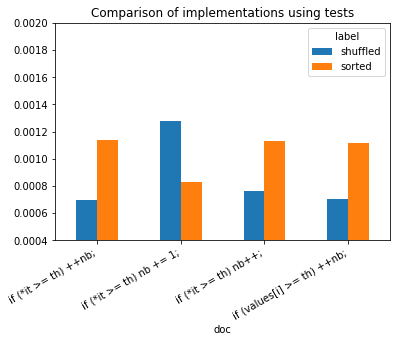

In [13]:
sdf = df[["doc", "label", "average"]]
dfg2 = sdf[sdf.doc.str.contains('if')].pivot("doc", "label", "average")
ax = dfg2.plot.bar(rot=30)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
ax.set_ylim([0.0004, 0.0020])
ax.set_title("Comparison of implementations using tests");

*sorted*, *not sorted* does not seem to have a real impact in this case. It shows *branching* really slows down the execution of a program. Branching happens whenever the program meets a loop condition or a test. Iterator ``*it`` are faster than accessing an array with notation ``[i]`` which adds a cost due to an extra addition.

## Second experiment: dot product

The goal is to compare the dot product from [numpy.dot](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.dot.html) and a couple of implementation in C++ which look like this:

In [14]:
# float vector_dot_product_pointer(const float *p1, const float *p2, size_t size)
# {
#     float sum = 0;
#     const float * end1 = p1 + size;
#     for(; p1 != end1; ++p1, ++p2)
#         sum += *p1 * *p2;
#     return sum;
# }
# 
# 
# float vector_dot_product(py::array_t<float> v1, py::array_t<float> v2)
# {
#     if (v1.ndim() != v2.ndim())
#         throw std::runtime_error("Vector v1 and v2 must have the same dimension.");
#     if (v1.ndim() != 1)
#         throw std::runtime_error("Vector v1 and v2 must be vectors.");
#     return vector_dot_product_pointer(v1.data(0), v2.data(0), v1.shape(0));
# }

### numpy vs C++

#### numpy.dot

In [15]:
%matplotlib inline

In [16]:
import numpy

def simple_dot(values):
    return numpy.dot(values, values)

values = list(range(10000000))
values = numpy.array(values, dtype=numpy.float32)
vect = values / numpy.max(values)
simple_dot(vect)

3333333.2

In [17]:
vect.dtype

dtype('float32')

In [18]:
from timeit import Timer

def measure_time(stmt, context, repeat=10, number=50):
    tim = Timer(stmt, globals=context)
    res = numpy.array(tim.repeat(repeat=repeat, number=number))
    mean = numpy.mean(res)
    dev = numpy.mean(res ** 2)
    dev = (dev - mean**2) ** 0.5
    return dict(average=mean, deviation=dev, min_exec=numpy.min(res),
                max_exec=numpy.max(res), repeat=repeat, number=number,
                size=context['values'].shape[0])

measure_time("simple_dot(values)", context=dict(simple_dot=simple_dot, values=vect))

{'average': 0.17493714570000024,
 'deviation': 0.01055679328637683,
 'min_exec': 0.16323108099999928,
 'max_exec': 0.1946009330000038,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [19]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("simple_dot(values)", repeat=100,
                     context=dict(simple_dot=simple_dot, values=vect[:i].copy()))
    res.append(t)

import pandas
dot = pandas.DataFrame(res)
dot.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.001811,0.000932,0.009380,0.001230,50,100,187510
76,0.001646,0.000415,0.003583,0.001249,50,100,190010
77,0.001981,0.000676,0.004695,0.001267,50,100,192510
78,0.002436,0.000855,0.004890,0.001313,50,100,195010
79,0.001886,0.000353,0.002882,0.001327,50,100,197510


In [20]:
res = []
for i in range(100000, 10000000, 1000000):
    t = measure_time("simple_dot(values)", repeat=10,
                     context=dict(simple_dot=simple_dot, values=vect[:i].copy()))
    res.append(t)
    
huge_dot = pandas.DataFrame(res)
huge_dot.head()

,average,deviation,max_exec,min_exec,number,repeat,size
0,0.000914,0.000144,0.001219,0.000820,50,10,100000
1,0.015862,0.004123,0.027136,0.012628,50,10,1100000
2,0.035084,0.003601,0.042250,0.030178,50,10,2100000
3,0.048146,0.001690,0.050411,0.045873,50,10,3100000
4,0.070299,0.005897,0.086010,0.066763,50,10,4100000


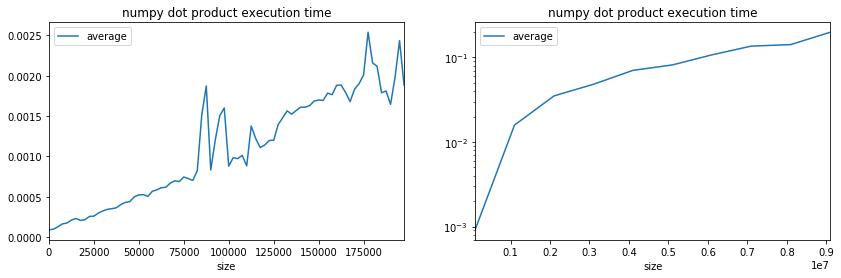

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0])
huge_dot.plot(x='size', y="average", ax=ax[1], logy=True)
ax[0].set_title("numpy dot product execution time");
ax[1].set_title("numpy dot product execution time");

#### numpy.einsum

In [22]:
def simple_dot_einsum(values):
    return numpy.einsum('i,i->', values, values)

values = list(range(10000000))
values = numpy.array(values, dtype=numpy.float32)
vect = values / numpy.max(values)
simple_dot_einsum(vect)

3333333.8

In [23]:
measure_time("simple_dot_einsum(values)",
             context=dict(simple_dot_einsum=simple_dot_einsum, values=vect))

{'average': 0.2862720898999996,
 'deviation': 0.019172035812954895,
 'min_exec': 0.26404798899999093,
 'max_exec': 0.3281182589999929,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [24]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("simple_dot_einsum(values)", repeat=100,
                     context=dict(simple_dot_einsum=simple_dot_einsum, values=vect[:i].copy()))
    res.append(t)

import pandas
einsum_dot = pandas.DataFrame(res)
einsum_dot.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.004400,0.001858,0.009241,0.003290,50,100,187510
76,0.003400,0.000065,0.003683,0.003320,50,100,190010
77,0.003717,0.000703,0.007098,0.003467,50,100,192510
78,0.003628,0.000256,0.004555,0.003404,50,100,195010
79,0.003660,0.000224,0.004962,0.003448,50,100,197510


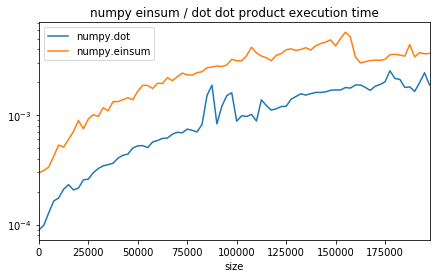

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(7,4))
dot.plot(x='size', y="average", ax=ax, label="numpy.dot", logy=True)
einsum_dot.plot(x='size', y="average", ax=ax, logy=True,label="numpy.einsum")
ax.set_title("numpy einsum / dot dot product execution time");

The function [einsum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html) is slower (see [Einsum - Einstein summation in deep learning](https://rockt.github.io/2018/04/30/einsum) appears to be slower but it is usually faster when it comes to chain operations as it reduces the number of intermediate allocations to do.

#### pybind11

Now the custom implementation. We start with an empty function to get a sense of the cost due to to pybind11.

In [26]:
from cpyquickhelper.numbers.cbenchmark_dot import empty_vector_dot_product
empty_vector_dot_product(vect, vect)

0.0

In [27]:
def empty_c11_dot(vect):
    return empty_vector_dot_product(vect, vect)

measure_time("empty_c11_dot(values)", 
             context=dict(empty_c11_dot=empty_c11_dot, values=vect), repeat=10)

{'average': 0.0001423012999993034,
 'deviation': 4.8738723576776925e-05,
 'min_exec': 0.00010429600000350092,
 'max_exec': 0.00025876499999810676,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

Very small. It should not pollute our experiments.

In [28]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product
vector_dot_product(vect, vect)

3334629.0

In [29]:
def c11_dot(vect):
    return vector_dot_product(vect, vect)

measure_time("c11_dot(values)", 
             context=dict(c11_dot=c11_dot, values=vect), repeat=10)

{'average': 0.8533396122000013,
 'deviation': 0.24492425073976992,
 'min_exec': 0.6820375839999997,
 'max_exec': 1.2789236320000015,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [30]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot(values)", repeat=10,
                     context=dict(c11_dot=c11_dot, values=vect[:i].copy()))
    res.append(t)

import pandas
cus_dot = pandas.DataFrame(res)
cus_dot.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.023365,0.001148,0.025472,0.021720,50,10,187510
76,0.024021,0.000643,0.025093,0.022678,50,10,190010
77,0.023822,0.001232,0.025876,0.021724,50,10,192510
78,0.023852,0.000867,0.025552,0.022637,50,10,195010
79,0.024870,0.000563,0.025481,0.023793,50,10,197510


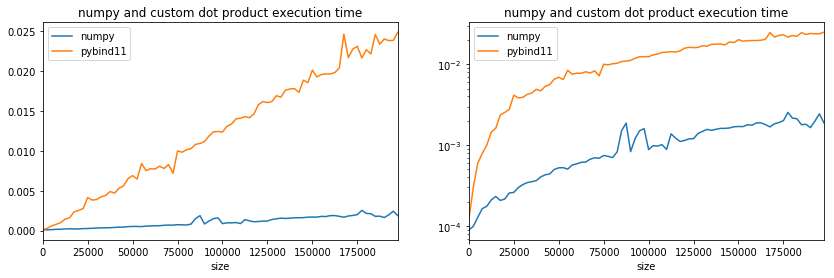

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

Pretty slow. Let's see what it does to compute dot product 16 by 16.

### BLAS

Internally, [numpy](http://www.numpy.org/) is using [BLAS](http://www.netlib.org/blas/). A direct call to it should give the same results.

In [32]:
from cpyquickhelper.numbers.direct_blas_lapack import cblas_sdot

def blas_dot(vect):
    return cblas_sdot(vect, vect)

measure_time("blas_dot(values)", context=dict(blas_dot=blas_dot, values=vect), repeat=10)

{'average': 0.18376368689999795,
 'deviation': 0.013271289356658413,
 'min_exec': 0.16785606499999517,
 'max_exec': 0.20954452600000195,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [33]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("blas_dot(values)", repeat=10,
                     context=dict(blas_dot=blas_dot, values=vect[:i].copy()))
    res.append(t)

import pandas
blas_dot = pandas.DataFrame(res)
blas_dot.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.002430,0.000223,0.002573,0.001950,50,10,187510
76,0.002326,0.000258,0.002600,0.001931,50,10,190010
77,0.002530,0.000197,0.002635,0.001977,50,10,192510
78,0.002071,0.000440,0.002698,0.001519,50,10,195010
79,0.002458,0.000400,0.003242,0.001869,50,10,197510


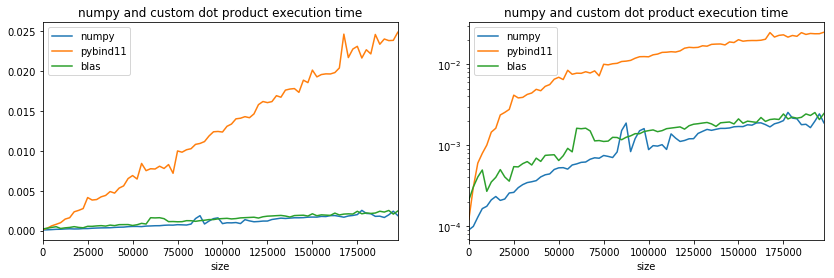

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
blas_dot.plot(x='size', y="average", ax=ax[0], label="blas")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
blas_dot.plot(x='size', y="average", ax=ax[1], label="blas")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

### Use of branching: 16 multplications in one row

The code looks like what follows. If there is more than 16 multiplications left, we use function *vector_dot_product_pointer16*, otherwise, there are done one by one like the previous function.

In [35]:
# float vector_dot_product_pointer16(const float *p1, const float *p2)
# {
#     float sum = 0;
#     
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
# 
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
#     sum += *(p1++) * *(p2++);
# 
#     return sum;
# }
# 
# #define BYN 16
# 
# float vector_dot_product_pointer16(const float *p1, const float *p2, size_t size)
# {
#     float sum = 0;
#     size_t i = 0;
#     if (size >= BYN) {
#         size_t size_ = size - BYN;
#         for(; i < size_; i += BYN, p1 += BYN, p2 += BYN)
#             sum += vector_dot_product_pointer16(p1, p2);
#     }
#     for(; i < size; ++p1, ++p2, ++i)
#         sum += *p1 * *p2;
#     return sum;
# }
# 
# float vector_dot_product16(py::array_t<float> v1, py::array_t<float> v2)
# {
#     if (v1.ndim() != v2.ndim())
#         throw std::runtime_error("Vector v1 and v2 must have the same dimension.");
#     if (v1.ndim() != 1)
#         throw std::runtime_error("Vector v1 and v2 must be vectors.");
#     return vector_dot_product_pointer16(v1.data(0), v2.data(0), v1.shape(0));
# }

In [36]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16
vector_dot_product16(vect, vect)

3333331.75

In [37]:
def c11_dot16(vect):
    return vector_dot_product16(vect, vect)

measure_time("c11_dot16(values)", 
             context=dict(c11_dot16=c11_dot16, values=vect), repeat=10)

{'average': 0.5628858367999967,
 'deviation': 0.006558496803961198,
 'min_exec': 0.5514294899999896,
 'max_exec': 0.5766948529999922,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [38]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16(values)", repeat=10,
                     context=dict(c11_dot16=c11_dot16, values=vect[:i].copy()))
    res.append(t)

cus_dot16 = pandas.DataFrame(res)
cus_dot16.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.010757,0.000345,0.011495,0.010465,50,10,187510
76,0.010169,0.000474,0.011362,0.009392,50,10,190010
77,0.010440,0.000449,0.011532,0.010153,50,10,192510
78,0.011015,0.000679,0.011867,0.009231,50,10,195010
79,0.011091,0.000540,0.012168,0.010415,50,10,197510


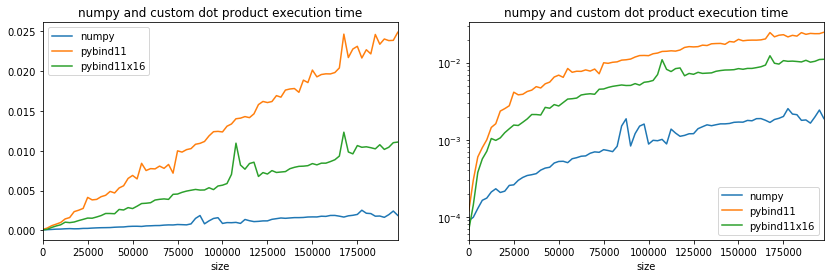

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[0], label="pybind11x16")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

We are far from *numpy* but the branching has clearly a huge impact and the fact the loop condition is evaluated only every 16 iterations does not explain this gain. Next experiment with [SSE](https://fr.wikipedia.org/wiki/Streaming_SIMD_Extensions) instructions.

### Optimized to remove function call

We remove the function call to get the following version.

In [40]:
# float vector_dot_product_pointer16_nofcall(const float *p1, const float *p2, size_t size)
# {
#     float sum = 0;    
#     const float * end = p1 + size;
#     if (size >= BYN) {
#         #if(BYN != 16)
#             #error "BYN must be equal to 16";
#         #endif
#         unsigned int size_ = (unsigned int) size;
#         size_ = size_ >> 4;  // division by 16=2^4
#         size_ = size_ << 4;  // multiplication by 16=2^4
#         const float * end_ = p1 + size_;
#         for(; p1 != end_;)
#         {
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
# 
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#             sum += *p1 * *p2; ++p1, ++p2;
#         }
#     }
#     for(; p1 != end; ++p1, ++p2)
#         sum += *p1 * *p2;
#     return sum;
# }
# 
# float vector_dot_product16_nofcall(py::array_t<float> v1, py::array_t<float> v2)
# {
#     if (v1.ndim() != v2.ndim())
#         throw std::runtime_error("Vector v1 and v2 must have the same dimension.");
#     if (v1.ndim() != 1)
#         throw std::runtime_error("Vector v1 and v2 must be vectors.");
#     return vector_dot_product_pointer16_nofcall(v1.data(0), v2.data(0), v1.shape(0));
# }

In [41]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16_nofcall
vector_dot_product16_nofcall(vect, vect)

3334629.0

In [42]:
def c11_dot16_nofcall(vect):
    return vector_dot_product16_nofcall(vect, vect)

measure_time("c11_dot16_nofcall(values)",
             context=dict(c11_dot16_nofcall=c11_dot16_nofcall, values=vect), repeat=10)

{'average': 1.2945859600000034,
 'deviation': 0.029453146426095998,
 'min_exec': 1.270528181000003,
 'max_exec': 1.3768783189999851,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [43]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16_nofcall(values)", repeat=10,
                     context=dict(c11_dot16_nofcall=c11_dot16_nofcall, values=vect[:i].copy()))
    res.append(t)

cus_dot16_nofcall = pandas.DataFrame(res)
cus_dot16_nofcall.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.023715,0.001017,0.025011,0.021424,50,10,187510
76,0.024223,0.000463,0.024711,0.023164,50,10,190010
77,0.024831,0.000362,0.025402,0.024273,50,10,192510
78,0.025039,0.000294,0.025515,0.024486,50,10,195010
79,0.026592,0.001819,0.031072,0.024430,50,10,197510


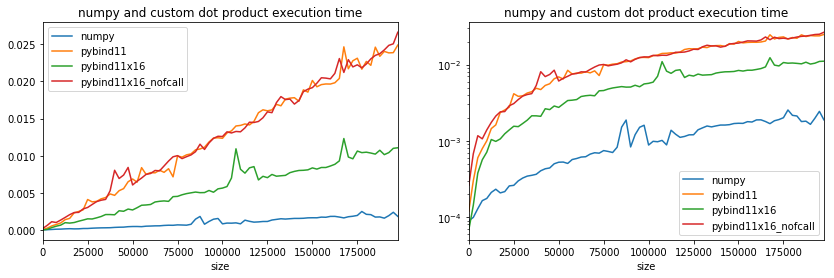

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot.plot(x='size', y="average", ax=ax[0], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[0], label="pybind11x16")
cus_dot16_nofcall.plot(x='size', y="average", ax=ax[0], label="pybind11x16_nofcall")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
cus_dot16_nofcall.plot(x='size', y="average", ax=ax[1], label="pybind11x16_nofcall")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

Weird, branching did not happen when the code is not inside a separate function.

### SSE instructions

We replace one function in the previous implementation.

In [45]:
# #include <xmmintrin.h>
# 
# float vector_dot_product_pointer16_sse(const float *p1, const float *p2)
# {
#     __m128 c1 = _mm_load_ps(p1);
#     __m128 c2 = _mm_load_ps(p2);
#     __m128 r1 = _mm_mul_ps(c1, c2);
#     
#     p1 += 4;
#     p2 += 4;
#     
#     c1 = _mm_load_ps(p1);
#     c2 = _mm_load_ps(p2);
#     r1 = _mm_add_ps(r1, _mm_mul_ps(c1, c2));
#     
#     p1 += 4;
#     p2 += 4;
#     
#     c1 = _mm_load_ps(p1);
#     c2 = _mm_load_ps(p2);
#     r1 = _mm_add_ps(r1, _mm_mul_ps(c1, c2));
#     
#     p1 += 4;
#     p2 += 4;
#     
#     c1 = _mm_load_ps(p1);
#     c2 = _mm_load_ps(p2);
#     r1 = _mm_add_ps(r1, _mm_mul_ps(c1, c2));
# 
#     float r[4];
#     _mm_store_ps(r, r1);
# 
#     return r[0] + r[1] + r[2] + r[3];
# }

In [46]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16_sse
vector_dot_product16_sse(vect, vect)

3333332.0

In [47]:
def c11_dot16_sse(vect):
    return vector_dot_product16_sse(vect, vect)

measure_time("c11_dot16_sse(values)", 
             context=dict(c11_dot16_sse=c11_dot16_sse, values=vect), repeat=10)

{'average': 0.22386672670000393,
 'deviation': 0.004340312827217225,
 'min_exec': 0.21708269199999108,
 'max_exec': 0.23220287799998118,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [48]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16_sse(values)", repeat=10,
                     context=dict(c11_dot16_sse=c11_dot16_sse, values=vect[:i].copy()))
    res.append(t)

cus_dot16_sse = pandas.DataFrame(res)
cus_dot16_sse.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.003629,0.000200,0.003825,0.003051,50,10,187510
76,0.003571,0.000230,0.003793,0.003063,50,10,190010
77,0.003642,0.000267,0.003821,0.003110,50,10,192510
78,0.003583,0.000285,0.003846,0.003146,50,10,195010
79,0.004467,0.000770,0.005784,0.003754,50,10,197510


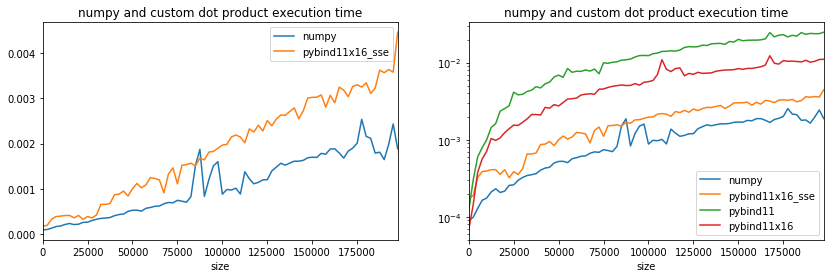

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot16_sse.plot(x='size', y="average", ax=ax[0], label="pybind11x16_sse")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot16_sse.plot(x='size', y="average", ax=ax[1], label="pybind11x16_sse")
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

Better even though it is still slower than *numpy*. It is closer. Maybe the compilation option are not optimized, *numpy* was also compiled with the Intel compiler. To be accurate, multi-threading must be disabled on *numpy* side. That's the purpose of the first two lines.

### AVX 512

Last experiment with [AVX 512](https://fr.wikipedia.org/wiki/Advanced_Vector_Extensions) instructions but it does not work on all processor. I could not test it on my laptop as these instructions do not seem to be available. More can be found on wikipedia [CPUs with AVX-512](https://en.wikipedia.org/wiki/AVX-512#CPUs_with_AVX-512).

In [50]:
import platform
platform.processor()

'Intel64 Family 6 Model 78 Stepping 3, GenuineIntel'

In [51]:
import numpy
values = numpy.array(list(range(10000000)), dtype=numpy.float32)
vect = values / numpy.max(values)

In [52]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product16_avx512
vector_dot_product16_avx512(vect, vect)

3333332.0

In [53]:
def c11_dot16_avx512(vect):
    return vector_dot_product16_avx512(vect, vect)

measure_time("c11_dot16_avx512(values)",
             context=dict(c11_dot16_avx512=c11_dot16_avx512, values=vect), repeat=10)

{'average': 0.24621207209999624,
 'deviation': 0.030678971301695272,
 'min_exec': 0.21640002699999172,
 'max_exec': 0.3037627230000055,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [54]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot16_avx512(values)", repeat=10,
                     context=dict(c11_dot16_avx512=c11_dot16_avx512, values=vect[:i].copy()))
    res.append(t)

cus_dot16_avx512 = pandas.DataFrame(res)
cus_dot16_avx512.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.003631,0.001094,0.005245,0.001953,50,10,187510
76,0.004108,0.001309,0.006254,0.002541,50,10,190010
77,0.003714,0.000933,0.005624,0.002511,50,10,192510
78,0.005389,0.001072,0.007044,0.003420,50,10,195010
79,0.005102,0.001096,0.008251,0.004557,50,10,197510


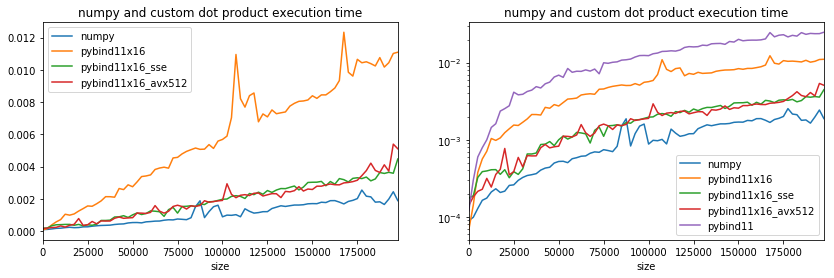

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot16.plot(x='size', y="average", ax=ax[0], label="pybind11x16")
cus_dot16_sse.plot(x='size', y="average", ax=ax[0], label="pybind11x16_sse")
cus_dot16_avx512.plot(x='size', y="average", ax=ax[0], label="pybind11x16_avx512")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
cus_dot16_sse.plot(x='size', y="average", ax=ax[1], label="pybind11x16_sse")
cus_dot16_avx512.plot(x='size', y="average", ax=ax[1], label="pybind11x16_avx512")
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

If the time is the same, it means that options AVX512 are not available.

In [56]:
from cpyquickhelper.numbers.cbenchmark import get_simd_available_option
get_simd_available_option()

'Available options:  __SSE__ __SSE2__ __SSE3__ __SSE4_1__'

## Last call with OpenMP


In [57]:
from cpyquickhelper.numbers.cbenchmark_dot import vector_dot_product_openmp
vector_dot_product_openmp(vect, vect, 2)

3348343.25

In [58]:
vector_dot_product_openmp(vect, vect, 4)

3343080.75

In [59]:
def c11_dot_openmp2(vect):
    return vector_dot_product_openmp(vect, vect, nthreads=2)

def c11_dot_openmp4(vect):
    return vector_dot_product_openmp(vect, vect, nthreads=4)

measure_time("c11_dot_openmp2(values)",
             context=dict(c11_dot_openmp2=c11_dot_openmp2, values=vect), repeat=10)

{'average': 0.6101010486999939,
 'deviation': 0.023996900833560427,
 'min_exec': 0.5678723409999975,
 'max_exec': 0.6511117819999299,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [60]:
measure_time("c11_dot_openmp4(values)",
             context=dict(c11_dot_openmp4=c11_dot_openmp4, values=vect), repeat=10)

{'average': 0.329937042999984,
 'deviation': 0.016537939361682446,
 'min_exec': 0.30559936400004517,
 'max_exec': 0.35731013800000255,
 'repeat': 10,
 'number': 50,
 'size': 10000000}

In [61]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot_openmp2(values)", repeat=10,
                     context=dict(c11_dot_openmp2=c11_dot_openmp2, values=vect[:i].copy()))
    res.append(t)

cus_dot_openmp2 = pandas.DataFrame(res)
cus_dot_openmp2.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.011458,0.000959,0.012970,0.010097,50,10,187510
76,0.011582,0.000723,0.012886,0.010232,50,10,190010
77,0.012416,0.000774,0.013324,0.011078,50,10,192510
78,0.013305,0.000465,0.013685,0.012125,50,10,195010
79,0.009506,0.001906,0.012279,0.007230,50,10,197510


In [62]:
res = []
for i in range(10, 200000, 2500):
    t = measure_time("c11_dot_openmp4(values)", repeat=10,
                     context=dict(c11_dot_openmp4=c11_dot_openmp4, values=vect[:i].copy()))
    res.append(t)

cus_dot_openmp4 = pandas.DataFrame(res)
cus_dot_openmp4.tail()

,average,deviation,max_exec,min_exec,number,repeat,size
75,0.006757,0.000376,0.007589,0.006341,50,10,187510
76,0.007416,0.001347,0.011127,0.006291,50,10,190010
77,0.006946,0.000783,0.008544,0.005562,50,10,192510
78,0.006466,0.000636,0.007366,0.005439,50,10,195010
79,0.006986,0.000389,0.007906,0.006533,50,10,197510


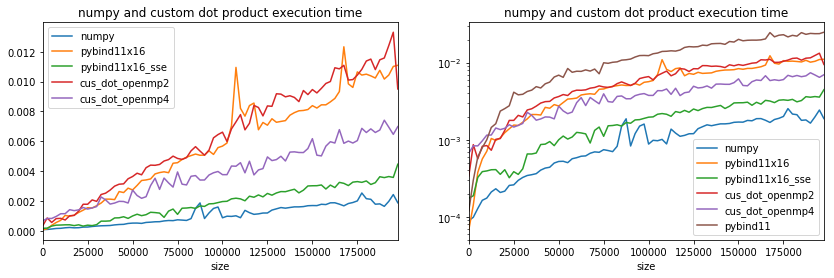

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
dot.plot(x='size', y="average", ax=ax[0], label="numpy")
cus_dot16.plot(x='size', y="average", ax=ax[0], label="pybind11x16")
cus_dot16_sse.plot(x='size', y="average", ax=ax[0], label="pybind11x16_sse")
cus_dot_openmp2.plot(x='size', y="average", ax=ax[0], label="cus_dot_openmp2")
cus_dot_openmp4.plot(x='size', y="average", ax=ax[0], label="cus_dot_openmp4")
dot.plot(x='size', y="average", ax=ax[1], label="numpy", logy=True)
cus_dot16.plot(x='size', y="average", ax=ax[1], label="pybind11x16")
cus_dot16_sse.plot(x='size', y="average", ax=ax[1], label="pybind11x16_sse")
cus_dot_openmp2.plot(x='size', y="average", ax=ax[1], label="cus_dot_openmp2")
cus_dot_openmp4.plot(x='size', y="average", ax=ax[1], label="cus_dot_openmp4")
cus_dot.plot(x='size', y="average", ax=ax[1], label="pybind11")
ax[0].set_title("numpy and custom dot product execution time");
ax[1].set_title("numpy and custom dot product execution time");

Parallelization does not solve everything, efficient is important.

### Back to numpy

This article [Why is matrix multiplication faster with numpy than with ctypes in Python?](https://stackoverflow.com/questions/10442365/why-is-matrix-multiplication-faster-with-numpy-than-with-ctypes-in-python) gives some kints on why *numpy* is still faster. By looking at the code of the dot product in *numpy*: [arraytypes.c.src](https://github.com/numpy/numpy/blob/master/numpy/core/src/multiarray/arraytypes.c.src), it seems that *numpy* does a simple dot product without using branching or uses the library [BLAS](http://www.netlib.org/blas/) which is the case in this benchmark (code for dot product: [sdot.c](http://www.netlib.org/clapack/cblas/sdot.c)). And it does use *branching*. See also function [blas_stride](https://github.com/numpy/numpy/blob/master/numpy/core/src/multiarray/common.h#L298). These libraries then play with [compilation options](https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html) and optimize for speed. This benchmark does not look into [cython-blis](https://github.com/explosion/cython-blis) which implements some [BLAS](http://www.netlib.org/blas/) functions with an assembly language and has different implementations depending on the platform it is used. A little bit more on C++ optimization [How to optimize C and C++ code in 2018](https://medium.com/@aka.rider/how-to-optimize-c-and-c-code-in-2018-bd4f90a72c2b).